In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data.dataloader as dataloader
import torch.optim as optim

from torch.utils.data import TensorDataset
from torch.autograd import Variable
from torchvision import transforms
from torchvision.datasets import MNIST

import copy

%matplotlib inline

In [2]:
test = MNIST('../DATASETS/MNIST_pytorch/', train=True, transform=transforms.Compose([
    transforms.ToTensor(), # ToTensor does min-max normalization. 
    ]),
#              download=True,
             )

train = MNIST('../DATASETS/MNIST_pytorch/', train=False, transform=transforms.ToTensor(),
#             download=True,
            )
## swapped the train and test for performing training on lower data size
# Create DataLoader
dataloader_args = dict(shuffle=True, batch_size=32)
train_loader = dataloader.DataLoader(train, **dataloader_args)
test_loader = dataloader.DataLoader(test, **dataloader_args)

In [3]:
# train.data.shape, train.targets.shape
train.data = train.data[:1000]
train.targets = train.targets[:1000]

In [4]:
train_data = train.data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.data.cpu().numpy().shape)
print(' - Tensor Shape:', train.data.size())
print(' - Transformed Shape:', train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

[Train]
 - Numpy Shape: (1000, 28, 28)
 - Tensor Shape: torch.Size([1000, 28, 28])
 - Transformed Shape: torch.Size([28, 1000, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1223)
 - std: tensor(0.2984)
 - var: tensor(0.0890)


In [5]:
test_data = test.data
test_data = train.transform(test_data.numpy())

print('[Test]')
print(' - Numpy Shape:', test.data.numpy().shape)
print(' - Tensor Shape:', test.data.size())
print(' - Transformed Shape:', test_data.size())
print(' - min:', torch.min(test_data))
print(' - max:', torch.max(test_data))
print(' - mean:', torch.mean(test_data))
print(' - std:', torch.std(test_data))
print(' - var:', torch.var(test_data))

[Test]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - Transformed Shape: torch.Size([28, 60000, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1306)
 - std: tensor(0.3081)
 - var: tensor(0.0949)


In [6]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        
        self.fc1 = nn.Linear(784, 10)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(10, 10)
        self.softmax = nn.LogSoftmax(dim=1)
        
        
    def forward(self, x):
        x = x.view((-1, 784))
        h = self.fc1(x)
        h = F.relu(h)        
        h = self.fc2(h)
        out = self.softmax(h)
        return out

In [7]:
model = Model()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [8]:
# model.train()
evaluate_x = Variable(test_loader.dataset.data.type_as(torch.FloatTensor()))
evaluate_y = Variable(test_loader.dataset.targets)

losses = []
EPOCHS = 50 #5
for epoch in range(EPOCHS):
    data_count = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        # Init
        optimizer.zero_grad()

        # Predict
        y_pred = model(data) 

        # Calculate loss
        loss = criterion(y_pred, target)
        losses.append(loss.data)
        
        # Backpropagation
        loss.backward()
        optimizer.step()
        
        
        # Display
        data_count += len(data)
        if batch_idx%100 == 0 or batch_idx==len(train_loader)-1:
            output = model(evaluate_x)
            pred = output.max(1)[1]
            d = pred.eq(evaluate_y)
            accuracy = float(d.sum())/float(d.size()[0])
            
            print('\r Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tAccuracy: {}'.format(
                epoch, 
                data_count, 
                len(train_loader.dataset),
                100. * batch_idx / len(train_loader), 
                loss.data,
                accuracy,),
                end='')
            
    print()

 Train Epoch: 0 [1000/1000 (97%)]	Loss: 2.063272	Accuracy: 0.3520333333333333
 Train Epoch: 1 [1000/1000 (97%)]	Loss: 1.738257	Accuracy: 0.40815
 Train Epoch: 2 [1000/1000 (97%)]	Loss: 1.543414	Accuracy: 0.5328166666666667
 Train Epoch: 3 [1000/1000 (97%)]	Loss: 0.959627	Accuracy: 0.6022
 Train Epoch: 4 [1000/1000 (97%)]	Loss: 1.053680	Accuracy: 0.6607333333333333
 Train Epoch: 5 [1000/1000 (97%)]	Loss: 0.670349	Accuracy: 0.70435
 Train Epoch: 6 [1000/1000 (97%)]	Loss: 1.130978	Accuracy: 0.7230333333333333
 Train Epoch: 7 [1000/1000 (97%)]	Loss: 0.521323	Accuracy: 0.7491833333333333
 Train Epoch: 8 [1000/1000 (97%)]	Loss: 0.559209	Accuracy: 0.7648333333333334
 Train Epoch: 9 [1000/1000 (97%)]	Loss: 0.642448	Accuracy: 0.7754333333333333
 Train Epoch: 10 [1000/1000 (97%)]	Loss: 0.290685	Accuracy: 0.7855566666667
 Train Epoch: 11 [1000/1000 (97%)]	Loss: 0.371254	Accuracy: 0.7935166666666666
 Train Epoch: 12 [1000/1000 (97%)]	Loss: 0.472344	Accuracy: 0.8026566666667
 Train Epoch: 13 [1000/

(0.39245552, 0.46346888)

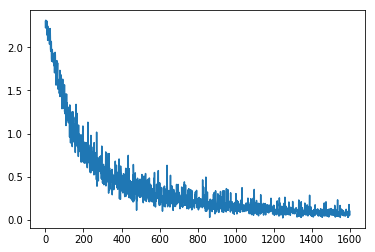

In [9]:
plt.plot(losses)
np.mean(losses), np.std(losses)

In [10]:
for model_parm in model.parameters():
        model_parm.requires_grad=False

In [11]:
evaluate_x = test.data.type_as(torch.FloatTensor())
evaluate_y = test_loader.dataset.targets


output = model(evaluate_x)
pred = output.max(dim=1)[1]
d = pred.eq(evaluate_y)
accuracy = float(d.sum())/float(d.size()[0])

print('Accuracy:', accuracy)

Accuracy: 0.85545


In [12]:
a = 1

In [13]:
print(-a)
print(losses[-a])
a+=1

-1
tensor(0.0982)


### Using  error to predict using another network

In [14]:
train_x = train_loader.dataset.data.type_as(torch.FloatTensor())
train_y = train_loader.dataset.targets

# with torch.no_grad():
x = train_x.view((-1, 784))
h = model.fc1(x)
h = F.relu(h)        
prev_final = model.fc2(h)
# out = model.softmax(h)

# with torch.no_grad():
x = evaluate_x.view((-1, 784))
h = model.fc1(x)
h = F.relu(h)        
prev_test_final = model.fc2(h)

In [15]:
class CustomMNIST(torch.utils.data.Dataset):

    def __init__(self, inputs, targets, prev_final):
        self.inputs = inputs
        self.targets = targets
        self.prev_final = prev_final

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        return self.inputs[idx], self.targets[idx], self.prev_final[idx]

In [16]:
error0MNIST = CustomMNIST(train_x, train_y, prev_final.data)
dataloader_args = dict(shuffle=True, batch_size=32)
train1_loader = dataloader.DataLoader(error0MNIST, **dataloader_args)

In [17]:
class ModelE(nn.Module):
    def __init__(self):
        super(ModelE, self).__init__()
        
        self.fc1 = nn.Linear(784, 10)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(10, 10)
        self.fc2.weight.data *= 0.
        self.softmax = nn.LogSoftmax(dim=1)
        
        
    def forward(self, x, prev_final):
        x = x.view((-1, 784))
        h = self.fc1(x)
        h = F.relu(h)        
        h = self.fc2(h)
        if prev_final is not None:
            h = h + prev_final
        out = self.softmax(h)
        return out

In [26]:
model1 = ModelE()
optimizer1 = optim.Adam(model1.parameters(), lr=0.001)
criterion1 = nn.CrossEntropyLoss()

In [27]:
losses1 = []
EPOCHS = 50 #5
for epoch in range(EPOCHS):
    data_count = 0
    max_iter = 0
    for batch_idx, (data, target, prev_final) in enumerate(train1_loader):

        y_pred = model1(data, prev_final) 
        loss = criterion(y_pred, target)
        losses1.append(loss.data)
        
        # Backpropagation
        optimizer1.zero_grad()
        loss.backward()
        optimizer1.step()
        
        # Display
        data_count += len(data)
        if batch_idx%100 == 0 or batch_idx==len(train_loader)-1:
            output = model1(evaluate_x, prev_test_final)
            pred = output.max(1)[1]
            d = pred.eq(evaluate_y)
            accuracy = float(d.sum())/float(d.size()[0])
            
            print('\r Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tAccuracy: {}, M : {} --->'.format(
                epoch, 
                data_count, 
                len(train_loader.dataset),
                100. * batch_idx / len(train_loader), 
                loss.data,
                accuracy,
                max_iter,),
                end='')
            
    print()

 Train Epoch: 0 [1000/1000 (97%)]	Loss: 0.000000	Accuracy: 0.8557166666666667, M : 0 --->
 Train Epoch: 1 [1000/1000 (97%)]	Loss: 0.000000	Accuracy: 0.85625, M : 0 --->: 0 --->
 Train Epoch: 2 [1000/1000 (97%)]	Loss: 0.813971	Accuracy: 0.8560833333333333, M : 0 --->
 Train Epoch: 3 [1000/1000 (97%)]	Loss: 0.000000	Accuracy: 0.8566666666666667, M : 0 --->
 Train Epoch: 4 [1000/1000 (97%)]	Loss: 0.000000	Accuracy: 0.8560333333333333, M : 0 --->
 Train Epoch: 5 [1000/1000 (97%)]	Loss: 0.000000	Accuracy: 0.85525, M : 0 --->
 Train Epoch: 6 [1000/1000 (97%)]	Loss: 0.000000	Accuracy: 0.8551333333333333, M : 0 --->
 Train Epoch: 7 [1000/1000 (97%)]	Loss: 0.000000	Accuracy: 0.8558, M : 0 ---> : 0 --->
 Train Epoch: 8 [1000/1000 (97%)]	Loss: 0.000000	Accuracy: 0.8556833333333334, M : 0 --->
 Train Epoch: 9 [1000/1000 (97%)]	Loss: 0.000000	Accuracy: 0.85495, M : 0 --->
 Train Epoch: 10 [1000/1000 (97%)]	Loss: 0.000000	Accuracy: 0.8553166666666666, M : 0 --->
 Train Epoch: 11 [1000/1000 (97%)]	Lo

(0.13028376, 1.2406006)

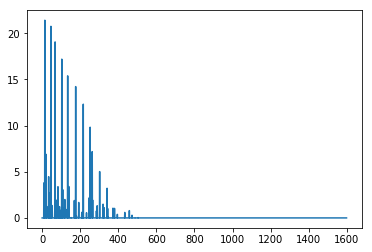

In [28]:
plt.plot(losses1)
np.mean(losses1), np.std(losses1)

In [29]:
output = model1(evaluate_x, prev_test_final)
pred = output.max(1)[1]
d = pred.eq(evaluate_y)
accuracy = float(d.sum())/float(d.size()[0])
accuracy

0.85565

## visualizing weights

In [30]:
i=0

0


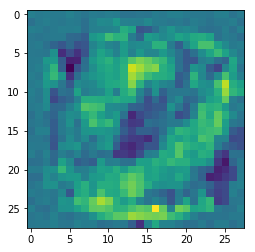

In [31]:
img = model.fc1.weight.data[i].numpy().reshape(28,28)
plt.imshow(img)
print(i)
i+=1

0


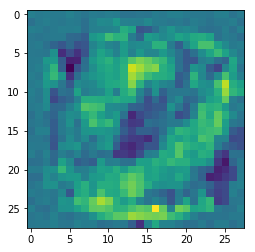

1


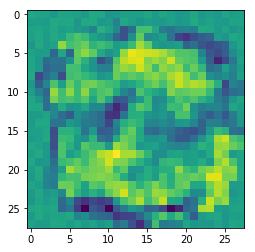

2


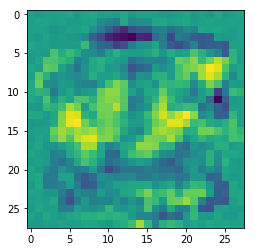

3


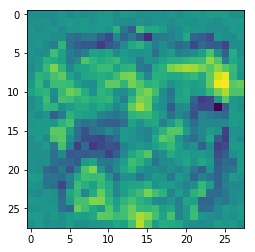

4


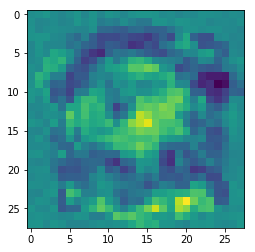

5


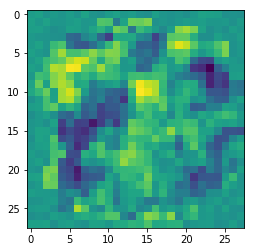

6


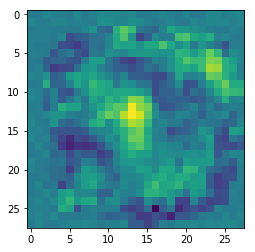

7


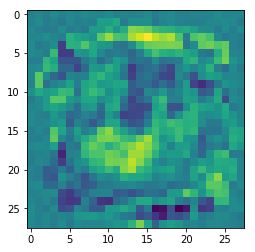

8


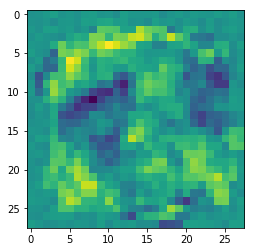

9


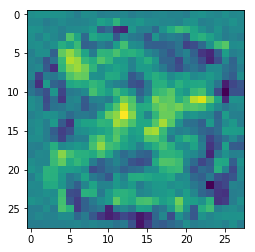

In [32]:
for i in range(10):
    img = model.fc1.weight.data[i].numpy().reshape(28,28)
    plt.imshow(img)
    print(i)
    plt.show()

0


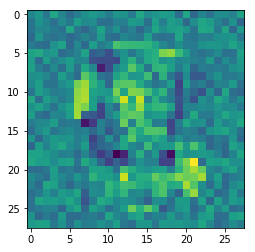

1


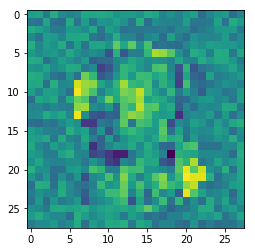

2


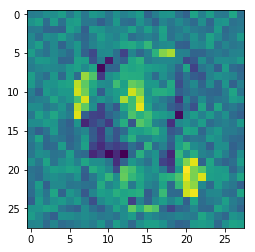

3


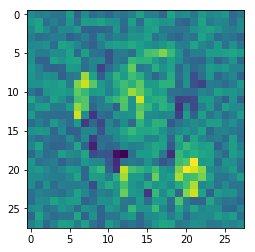

4


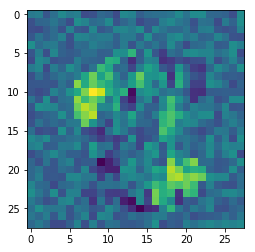

5


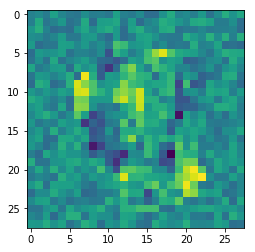

6


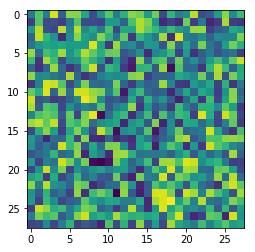

7


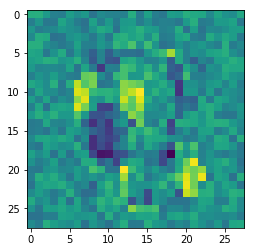

8


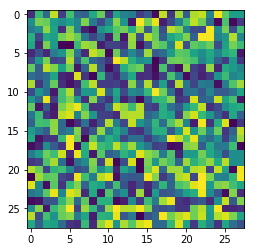

9


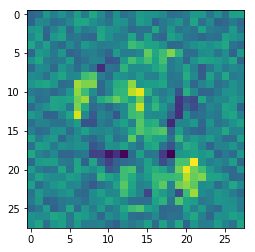

In [33]:
for i in range(10):
    img = model1.fc1.weight.data[i].numpy().reshape(28,28)
    plt.imshow(img)
    print(i)
    plt.show()